# Overview
This notebook documents the initial preprocessing of the dataset and training of a logistical regression model to establish a baseline for our analysis. Excluding the target, there are a total of 13 features. Most of them are categorical and missing values to varying degrees.

In [1]:
# Import dependencies.
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Read in the data.
df = pd.read_csv('/content/hr_job_change.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18014 entries, 0 to 18013
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             18014 non-null  int64  
 1   city                    18014 non-null  object 
 2   city_development_index  18014 non-null  float64
 3   gender                  18014 non-null  object 
 4   relevent_experience     18014 non-null  object 
 5   enrolled_university     18014 non-null  object 
 6   education_level         18014 non-null  object 
 7   major_discipline        18014 non-null  object 
 8   experience              18014 non-null  object 
 9   company_size            18014 non-null  object 
 10  company_type            18014 non-null  object 
 11  last_new_job            18014 non-null  object 
 12  training_hours          18014 non-null  int64  
 13  target                  18014 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [3]:
# Summarize the features with missing values.
df.isnull().sum()[df.isnull().sum() != 0]

Series([], dtype: int64)

# Features
Data transformation, including filling in missing values, for each feature is looked at individually.

## 0. `enrollee_id`
`enrollee_id` is used to identify those enrolled in the program. Since it is unique for each record and has no bearing on the target, it can be dropped.

In [4]:
df.enrollee_id.nunique()

18014

In [5]:
df.drop(columns='enrollee_id', inplace=True)

## 1. `city`
`city` with low counts can be binned together to reduce the total number of categories.

In [6]:
df.city.value_counts(dropna=False).head(20)

city_103    4194
city_21     2454
city_16     1471
city_114    1254
city_160     817
city_136     542
city_67      414
city_75      295
city_102     287
city_104     287
city_73      270
city_100     259
city_71      256
city_11      231
city_61      191
city_28      183
city_90      178
city_23      173
city_65      165
city_36      154
Name: city, dtype: int64

In [7]:
# Create a bin for cities with fewer than `threshold` instances.
threshold = 200
city_counts = df['city'].value_counts()
cities_to_replace = city_counts[city_counts<threshold].index

for city in cities_to_replace:
    df['city'] = df['city'].replace(city, 'Other')

df['city'].value_counts(dropna=False)

Other       4983
city_103    4194
city_21     2454
city_16     1471
city_114    1254
city_160     817
city_136     542
city_67      414
city_75      295
city_102     287
city_104     287
city_73      270
city_100     259
city_71      256
city_11      231
Name: city, dtype: int64

## 2. `city_development_index`
This is one of the two numerical features in the dataset, and it is already scaled. If the `city` values are kept, it can be confirmed that each city has a single `city_development_index`, but different cities might share the same value: `all(df.groupby('city')['city_development_index'].nunique() == 1)` returns `True`.

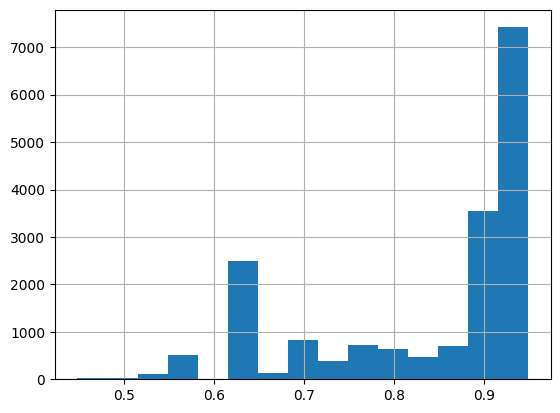

In [8]:
# Create a histogram for `city_development_index`.
df['city_development_index'].hist(bins=15);

## 3. `gender`
Missing values need to be dealt with. It's not immediately clear how to go about it: do we impute with the most frequent value to simply group it with `Other`? Since there are 10 males to 1 female in this training problem, we can approach this problem with filling in the missing values with the most frequent value of the feature, i.e., `Male`. The same approach is used for the other categorical features unless otherwise stated.

In [9]:
df['gender'].value_counts(dropna=False)

Male      16634
Female     1207
Other       173
Name: gender, dtype: int64

In [10]:
df['gender'].fillna('Male', inplace=True)
df['gender'].value_counts(dropna=False)

Male      16634
Female     1207
Other       173
Name: gender, dtype: int64

## 4. `relevent_experience`
This is one of the few categorical features without missing values. Since it refers to the individual having or not having relevant experience, and it can be converted to `1`'s and `0`'s.

In [11]:
df['relevent_experience'].value_counts(dropna=False)

Has relevent experience    13190
No relevent experience      4824
Name: relevent_experience, dtype: int64

In [12]:
df['relevent_experience'].replace('Has relevent experience', 1, inplace=True)
df['relevent_experience'].replace('No relevent experience', 0, inplace=True)
df['relevent_experience'].value_counts(dropna=False)

1    13190
0     4824
Name: relevent_experience, dtype: int64

## 5. `enrolled_university`
Missing values are imputed with the most frequent value.

In [13]:
df['enrolled_university'].value_counts(dropna=False)

no_enrollment       13348
Full time course     3517
Part time course     1149
Name: enrolled_university, dtype: int64

In [14]:
df['enrolled_university'].fillna('no_enrollment', inplace=True)
df['enrolled_university'].replace('no_enrollment', 'none', inplace=True)
df['enrolled_university'].replace('Full time course', 'full-time', inplace=True)
df['enrolled_university'].replace('Part time course', 'part-time', inplace=True)
df['enrolled_university'].value_counts(dropna=False)

none         13348
full-time     3517
part-time     1149
Name: enrolled_university, dtype: int64

## 6. `education_level`
Missing values are imputed with the most frequent value.

In [15]:
df['education_level'].value_counts(dropna=False)

Graduate          11188
Masters            4228
High School        1908
Phd                 399
Primary School      291
Name: education_level, dtype: int64

In [16]:
df['education_level'].fillna('Graduate', inplace=True)
df['education_level'].value_counts(dropna=False)

Graduate          11188
Masters            4228
High School        1908
Phd                 399
Primary School      291
Name: education_level, dtype: int64

## 7. `major_discipline`
Missing values are imputed with the most frequent value. STEM stands for science, technology, engineering and mathematics.

In [17]:
df['major_discipline'].value_counts(dropna=False)

STEM               16214
Humanities           654
Other                364
Business Degree      322
Arts                 248
No Major             212
Name: major_discipline, dtype: int64

In [18]:
df['major_discipline'].fillna('STEM', inplace=True)
df['major_discipline'].value_counts(dropna=False)

STEM               16214
Humanities           654
Other                364
Business Degree      322
Arts                 248
No Major             212
Name: major_discipline, dtype: int64

## 8. `experience`
Missing values for candidate's total experience in years are imputed with the most frequent value.

In [19]:
df['experience'].value_counts(dropna=False)

>20    3182
5      1337
4      1298
3      1223
6      1143
2       997
7       982
10      946
9       936
8       768
15      668
11      649
14      569
16      488
1       475
12      475
<1      451
13      387
17      331
19      294
18      273
20      142
Name: experience, dtype: int64

In [20]:
df['experience'].fillna('>20', inplace=True)
df['experience'].value_counts(dropna=False)

>20    3182
5      1337
4      1298
3      1223
6      1143
2       997
7       982
10      946
9       936
8       768
15      668
11      649
14      569
16      488
1       475
12      475
<1      451
13      387
17      331
19      294
18      273
20      142
Name: experience, dtype: int64

In [21]:
# Create bins for boarder categorization of experience.
for exp in ['<1', '1', '2']:
    df['experience'].replace(exp, '0-2', inplace=True)
for exp in ['3', '4']:
    df['experience'].replace(exp, '3-4', inplace=True)
for exp in ['5', '6', '7', '8', '9']:
    df['experience'].replace(exp, '5-9', inplace=True)
for exp in ['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '>20']:
    df['experience'].replace(exp, '>=10', inplace=True)

df['experience'].value_counts(dropna=False)

>=10    8404
5-9     5166
3-4     2521
0-2     1923
Name: experience, dtype: int64

## 9. `company_size`
Missing values for the company size are imputed with the most frequent value.

In [22]:
df['company_size'].value_counts(dropna=False)

50-99        5387
10000+       3270
100-500      2868
<10          2367
10/49        1428
1000-4999    1305
500-999       847
5000-9999     542
Name: company_size, dtype: int64

In [23]:
df['company_size'].replace('10/49', '10-49', inplace=True)
df['company_size'].replace('10000+', '>10000', inplace=True)
df['company_size'].fillna('50-99', inplace=True)
df['company_size'].value_counts(dropna=False)

50-99        5387
>10000       3270
100-500      2868
<10          2367
10-49        1428
1000-4999    1305
500-999       847
5000-9999     542
Name: company_size, dtype: int64

## 10. `company_type`
Missing values for the company type are imputed with the most frequent value.

In [24]:
df['company_type'].value_counts(dropna=False)

Pvt Ltd                14870
Public Sector            992
Funded Startup           975
Early Stage Startup      562
NGO                      501
Other                    114
Name: company_type, dtype: int64

In [25]:
df['company_type'].fillna('Pvt Ltd', inplace=True)
df['company_type'].value_counts(dropna=False)

Pvt Ltd                14870
Public Sector            992
Funded Startup           975
Early Stage Startup      562
NGO                      501
Other                    114
Name: company_type, dtype: int64

## 11. `last_new_job`
Missing values for difference in years between previous and current job are imputed with the most frequent value.

In [26]:
df['last_new_job'].value_counts(dropna=False)

1        7789
>4       3210
2        2827
never    2187
4        1010
3         991
Name: last_new_job, dtype: int64

In [27]:
df['last_new_job'].fillna('1', inplace=True)
df['last_new_job'].value_counts(dropna=False)

1        7789
>4       3210
2        2827
never    2187
4        1010
3         991
Name: last_new_job, dtype: int64

## 12. `training_hours`

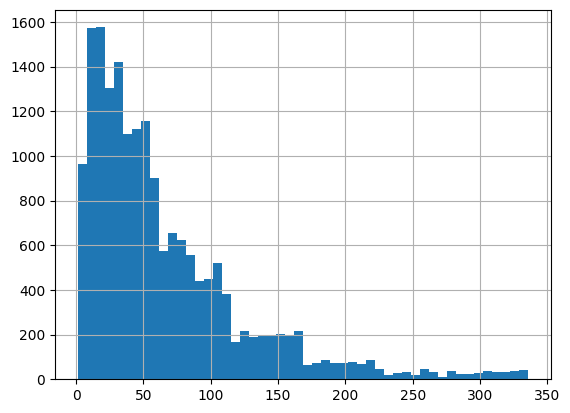

In [28]:
df['training_hours'].hist(bins=50);

## 13. `target`
`target` is imbalanced, so it needs to be addressed by ensuring `stratify=y` and/or resampling.

In [29]:
df['target'].value_counts(dropna=False)

0.0    13593
1.0     4421
Name: target, dtype: int64

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18014 entries, 0 to 18013
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    18014 non-null  object 
 1   city_development_index  18014 non-null  float64
 2   gender                  18014 non-null  object 
 3   relevent_experience     18014 non-null  int64  
 4   enrolled_university     18014 non-null  object 
 5   education_level         18014 non-null  object 
 6   major_discipline        18014 non-null  object 
 7   experience              18014 non-null  object 
 8   company_size            18014 non-null  object 
 9   company_type            18014 non-null  object 
 10  last_new_job            18014 non-null  object 
 11  training_hours          18014 non-null  int64  
 12  target                  18014 non-null  float64
dtypes: float64(2), int64(2), object(9)
memory usage: 1.8+ MB


# Model Implementation

In [31]:
df = pd.get_dummies(df)
df.head()

,city_development_index,relevent_experience,training_hours,target,city_Other,city_city_100,city_city_102,city_city_103,city_city_104,city_city_11,...,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,0.920,1,36,1.0,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
1,0.776,0,47,0.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0.624,0,83,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0.767,1,8,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.764,1,24,1.0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [32]:
# Split the data into a training set and a testing set.
y = df.target
X = df.drop(columns='target')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Instantiate a StandardScaler instance.
scaler = StandardScaler()

# Fit the training data to the standard scaler.
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler.
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler.
X_test_scaled = X_scaler.transform(X_test)

In [33]:
# Due to imbalanced target values, instantiate the random oversampler model.
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_scaled, y_train)

## Logistic Regression Model

In [34]:
# Implement a logistic regression model.
classifier = LogisticRegression(solver='lbfgs', random_state=42)
classifier.fit(X_res, y_res)
predictions = classifier.predict(X_test_scaled)

In [35]:
# Display the accuracy score for the test dataset.
print(f'Accuracy score: {accuracy_score(y_test, predictions):.2f}')

Accuracy score: 0.74


In [36]:
# Display the confusion matrix.
confusion_matrix(y_test, predictions)

array([[2561,  838],
       [ 353,  752]])

| n=19158 | Predicted: Staying | Predicted: Leaving |
| --- | --- | --- |
| Actual: Staying | 2678 | 918 |
| Actual: Leaving | 313 | 881 |


In [37]:
# Display the classification report.
target_names = ['stay', 'leave']
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

        stay       0.88      0.75      0.81      3399
       leave       0.47      0.68      0.56      1105

    accuracy                           0.74      4504
   macro avg       0.68      0.72      0.68      4504
weighted avg       0.78      0.74      0.75      4504



Considering that a recall score of 0.74 is achieved for predicting individuals leaving their current employment, this is a good starting point for our analysis.

## K-Fold Cross Validation - Logistic Regression

---



In [38]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [39]:
# Code is sourced from https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

# Prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# Create model
model = LogisticRegression()

# Evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# Report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.777 (0.009)


In this case, with `logistic regression`, we can see that the model achieved an estimated classification accuracy of about `77.9%.` This model had preformed well as it is close and above 74% model accuracy.

## Random Forest Classifier Model

In [40]:
from sklearn.ensemble import RandomForestClassifier

# Create the random forest classifier instance
rf_model = RandomForestClassifier(n_estimators=500, random_state=42)
rf_model = rf_model.fit(X_res, y_res)
predictions = rf_model.predict(X_test_scaled)

# Display the accuracy score for the test dataset.
print(f'Accuracy score: {accuracy_score(y_test, predictions):.2f}')

# Display the confusion matrix.
confusion_matrix(y_test, predictions)

# Display the classification report.
target_names = ['stay', 'leave']
print(classification_report(y_test, predictions, target_names=target_names))

Accuracy score: 0.75
              precision    recall  f1-score   support

        stay       0.83      0.84      0.83      3399
       leave       0.48      0.45      0.47      1105

    accuracy                           0.75      4504
   macro avg       0.65      0.65      0.65      4504
weighted avg       0.74      0.75      0.74      4504



## K-Fold Cross Validation - Random Forest Classifier


In [41]:
# Code is sourced from https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

# Prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# Create model
model = RandomForestClassifier()

# Evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# Report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.754 (0.009)


In this case, with `random forest classifier`, we can see that the model achieved an estimated classification accuracy of about `75.4%.` This model had preformed well as it is close and above 75% model accuracy.